In [84]:
"""
Imports necessary for this notebook
"""
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import scipy.io as sio
from scipy.stats import norm
import shdom
import os

In [85]:
input_dir = '../Develop_Dynamic_cloud/experiments/AirMSPI/dynamic_medium/monochromatic'
measurements = shdom.AirMSPIDynamicMeasurements()
measurements.load_airmspi_measurements(input_dir)
cv_index = 17
if cv_index==3:
    dir_ = '../Develop_Dynamic_cloud/experiments/AirMSPI/dynamic_medium/monochromatic/logs/cvpr_num_mediums_21_sigma_60_cv_3-11-Nov-2020-18:02:29/FINAL_3D_extinction.mat'
if cv_index==10:
    dir_ = '../Develop_Dynamic_cloud/experiments/AirMSPI/dynamic_medium/monochromatic/logs/cvpr_num_mediums_21_sigma_60_cv_10-11-Nov-2020-21:27:11/FINAL_3D_extinction.mat'
if cv_index==17:
    dir_ = '../Develop_Dynamic_cloud/experiments/AirMSPI/dynamic_medium/monochromatic/logs/cvpr_num_mediums_21_sigma_60_cv_17-11-Nov-2020-23:32:28/FINAL_3D_extinction.mat'
data = sio.loadmat(dir_)
extinctions = data['estimated_extinction']

In [86]:
time_list = measurements.time_list

sigma = 60
cv_time = time_list[cv_index]
previous_time = time_list[cv_index-1]
next_time = time_list[cv_index+1]
previous_ext = extinctions[:,:,:,cv_index-1]
next_ext = extinctions[:,:,:,cv_index]
inter_extinction_data = previous_ext + (np.array(cv_time) - previous_time) * (next_ext
                                - previous_ext) / (next_time - previous_time)

In [87]:
time_list = measurements.time_list
time_list=np.delete(time_list, cv_index)
dt = time_list - cv_time
w = norm.pdf(dt / sigma)
w = w/np.sum(w)
# w = np.exp(-0.5*(dt / sigma)^2)
gaussian_extinction_data = np.sum(w[np.newaxis,np.newaxis,np.newaxis,:] * extinctions,-1)


In [88]:
class arg(object):
    def __init__(self):
        self.reff = 10
        self.veff = 0.1
[nx,ny,nz,nt] = extinctions.shape
wavelengths = measurements.wavelength
if not isinstance(wavelengths,list):
    wavelengths = [wavelengths]

grid =  shdom.Grid(bounding_box=measurements.bb,nx=nx,ny=ny,nz=nz)
# mie_table_paths = [
#     '../mie_tables/polydisperse/Water_{}nm.scat'.format(shdom.int_round(wavelength)) 
#     for wavelength in wavelengths
# ]
# mie = shdom.MiePolydisperse()
# mie.read_table('../mie_tables/polydisperse/Water_659nm.scat')
args= {'reff':10}

cloud_generator = shdom.generate.Homogeneous(arg())
cloud_generator._reff = 10
cloud_generator.add_mie('../mie_tables/polydisperse/Water_659nm.scat')
albedo = cloud_generator.get_albedo(wavelengths[0], grid)
phase = cloud_generator.get_phase(wavelengths[0], grid)
extinction = gaussian_extinction_data
        

Reading mie table from file: ../mie_tables/polydisperse/Water_659nm.scat


In [89]:
df = pd.read_csv('../ancillary_data/AFGL_summer_mid_lat.txt', comment='#', sep=' ')
temperatures = df['Temperature(k)'].to_numpy(dtype=np.float32)
altitudes = df['Altitude(km)'].to_numpy(dtype=np.float32)
temperature_profile = shdom.GridData(shdom.Grid(z=altitudes), temperatures)
air_grid = shdom.Grid(z=np.linspace(0, 20, 20))
rayleigh = shdom.Rayleigh(wavelengths[0])
rayleigh.set_profile(temperature_profile.resample(air_grid))
air = shdom.MultispectralScatterer()
air.add_scatterer(rayleigh.get_scatterer())
# scattrer = shdom.OpticalScatterer(wavelengths[0],shdom.GridData(grid,gaussian_extinction_data),albedo,phase)
scattrer = shdom.OpticalScatterer(wavelengths[0],shdom.GridData(grid,inter_extinction_data),albedo,phase)
dynamicscatterer = shdom.DynamicScatterer()

dynamicscatterer.add_temporary_scatterer(shdom.TemporaryScatterer(scattrer))
dynamicmedium = shdom.DynamicMedium(dynamicscatterer,air)

In [90]:
sun_azimuth_list = measurements.sun_azimuth_list
sun_zenith_list = measurements.sun_zenith_list

surface = shdom.LambertianSurface(albedo=0.04)
scene_params = shdom.SceneParameters(
                    wavelength=wavelengths[0],
                    surface=surface,
                    source=shdom.SolarSource(azimuth=sun_azimuth_list[cv_index], zenith=sun_zenith_list[cv_index])
    
                )
numerical_params = shdom.NumericalParameters(num_mu_bins=8, num_phi_bins=16)
dynamic_solver = shdom.DynamicRteSolver(scene_params=[[scene_params]], numerical_params=[[numerical_params]])
dynamic_solver.set_dynamic_medium(dynamicmedium)
dynamic_solver.solve(100)

adapt_grid_factor reduced to  4.062758524065763


In [91]:
projections = measurements._projections.projection_list[cv_index]
dynamic_proj = shdom.DynamicProjection([projections])
camera = shdom.DynamicCamera(shdom.RadianceSensor(),dynamic_proj)
interp_image = camera.render(dynamic_solver,72)


In [92]:
scattrer = shdom.OpticalScatterer(wavelengths[0],shdom.GridData(grid,gaussian_extinction_data),albedo,phase)
dynamicscatterer = shdom.DynamicScatterer()

dynamicscatterer.add_temporary_scatterer(shdom.TemporaryScatterer(scattrer))
dynamicmedium = shdom.DynamicMedium(dynamicscatterer,air)
dynamic_solver = shdom.DynamicRteSolver(scene_params=[[scene_params]], numerical_params=[[numerical_params]])
dynamic_solver.set_dynamic_medium(dynamicmedium)
dynamic_solver.solve(100)
gaussian_image = camera.render(dynamic_solver,72)

adapt_grid_factor reduced to  4.062758524065763


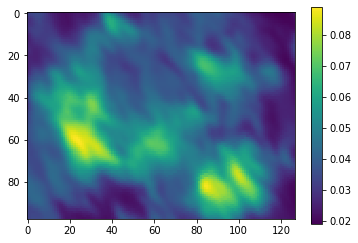

In [93]:
input_image = measurements.images[cv_index]
gaussian_image[0][input_image==0]=0
interp_image[0][input_image==0]=0
plt.imshow(input_image)
plt.colorbar()

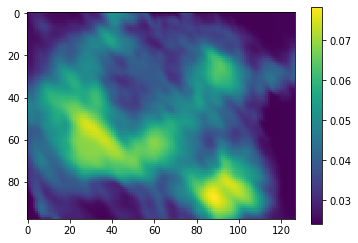

In [94]:
plt.imshow(interp_image[0])
plt.colorbar()

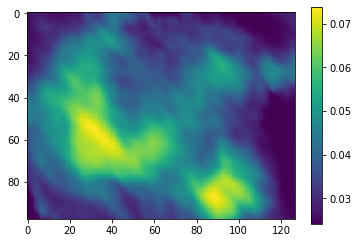

In [95]:
plt.imshow(gaussian_image[0])
plt.colorbar()

In [96]:
data = sio.savemat('sigma_60_{}.mat'.format(cv_index),{'input_image':input_image, 'interp_image':interp_image, 'gaussian_image':gaussian_image})
print(np.sum((np.array(interp_image) - np.array(input_image)).ravel() ** 2))
print(np.sum((np.array(gaussian_image) - np.array(input_image)).ravel() ** 2))

0.47771552
0.64763093
